# Concept Usage

The concept idea revolves around enhancing the interpretability and reasoning capabilities of deep learning models. By associating data points with high-level, interpretable concepts, we can gain insights into the model's decision-making process. This approach can help identify areas for improvement and ensure that the model's predictions align with human reasoning. 
Currently, we lack datasets that include predefined concept labels. To address this, we aim to extend existing datasets by automatically annotating them with high-level, interpretable concepts. 

In this library, several methods for concept extraction are implemented, divided into three main categories: AutoEncoder, ProtoAutoEncoder, and Wrapper. The ProtoAutoEncoder type is the one with the best results, as can also be seen from the distributions of the prototypes and record embeddings.

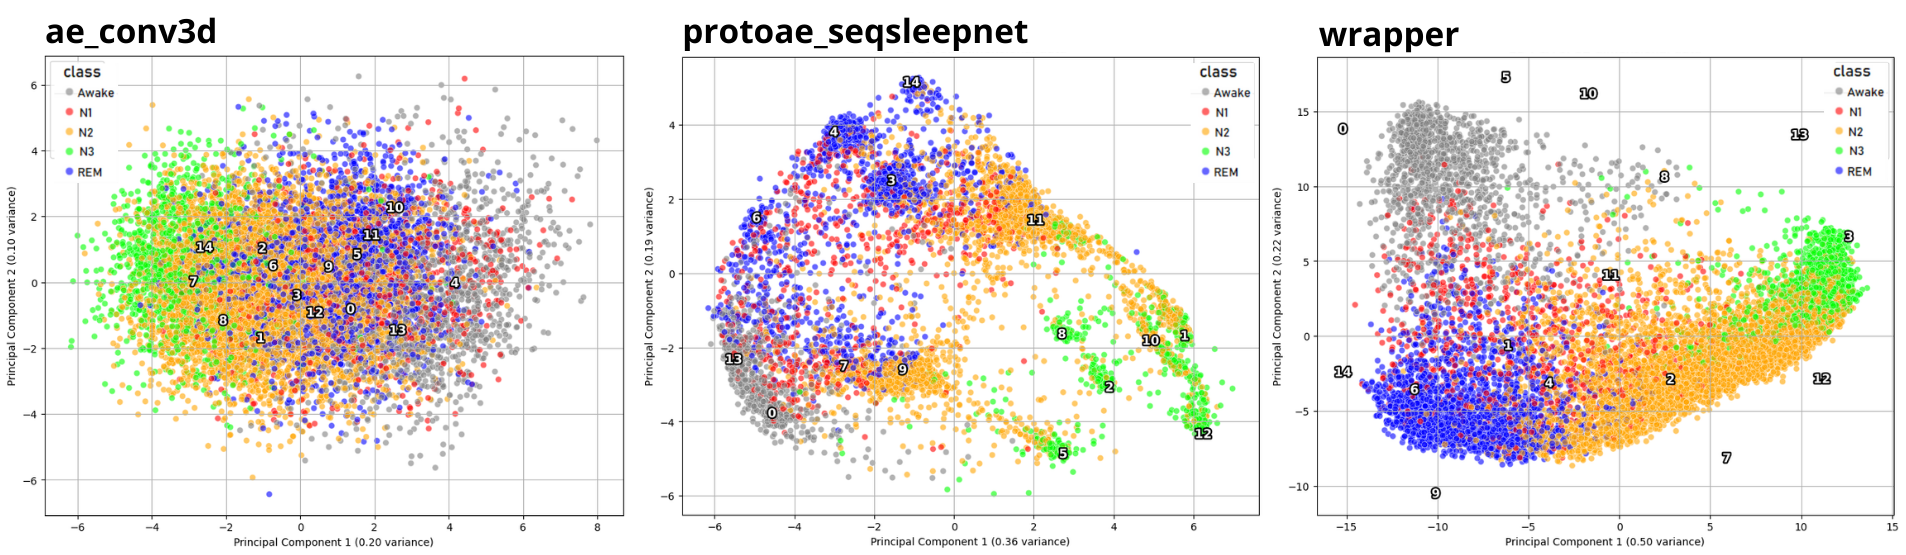


## Concept Labeling


In this notebook, we will exploit `ProtoAESeqSleepNet`. The model has been trained on a combination of datasets, including SHHS, MASS, DCSM, MROS, MESA, and HMC, to enable robust concept extraction across a variety of data sources. A checkpoint of the trained model is provided in the train/models/checkpoints folder.

Define the model class and its configuration parameters

In [5]:
import os
import importlib
# select the model to use for concept labeling, in this case the PrototypeAESeqSleepNet
model_class = "physioex.train.networks.protoae_seqsleepnet:PrototypeAESeqSleepNet"
module_name, class_name = model_class.split(":")
model_class = getattr(importlib.import_module(module_name), class_name)

Define the datamodule that will be used to load the the dataset you want to extend with concepts

In [2]:
from physioex.train.networks import config as networks_config
model_config = networks_config["default"]["model_kwargs"].copy()
datamodule_kwargs = {
    "selected_channels": ["EEG"],
    "sequence_length": 3,
    "target_transform": None, # needs to match model output
    "preprocessing": "xsleepnet", # needs to match model input
    "data_folder": "/mnt/guido-data/", # your custom path here
    "num_workers": os.cpu_count(), # default value
}
# now setup the ones that depends on the datamodule
model_config.update({
    "in_channels" : len(datamodule_kwargs["selected_channels"]),
    "sequence_length" : datamodule_kwargs["sequence_length"],
})


Create an instance of the concept labeler using your chosen model and datamodule, then execute it with the run method.

In [ ]:
from physioex.explain.concepts.concept_labeler import ConceptLabeler

concept_labeler = ConceptLabeler(
    dataset_name="mass",
    data_folder="mnt/guido-data/",
    model_class=model_class,
    model_config=model_config,
    model_ckpt_path="/home/manni/physioex/physioex/train/models/checkpoints/protoae_ssn-EEG-L=3-val_loss=5.42.ckpt",
    #model_ckpt_path=None,
    channels_index=[0],
    sequence_length=3
)

concept_labeler.run()

/home/manni/miniconda3/envs/physioex/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.3.2
2024-10-30 13:06:11.452 | INFO     | physioex.explain.concepts.concept_labeler:run:68 - Running the concept labeler ...
2024-10-30 13:06:11.453 | INFO     | physioex.explain.concepts.concept_labeler:run:77 - Computing the distances ...
100%|██████████| 201/201 [01:04<00:00,  3.11it/s]
2024-10-30 13:07:16.142 | INFO     | physioex.explain.concepts.concept_labeler:run:117 - Computing the concepts ...
100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


## Concept Models Training

Define the necessary configurations and parameters for training and evaluating our model. We are going to train the `SeqSleepNetCEM` model, which is configured with specific parameters to handle the EEG data

In [1]:
from physioex.train.utils import train
import os

# Note the best practice is to use a yaml file to store the arguments
# datamodule arguments

datamodule_kwargs = {
    "batch_size": 128,
    "selected_channels": ["EEG"],
    "sequence_length": 3,
    "target_transform": None, # needs to match model output
    "preprocessing": "xsleepnet", # needs to match model input
    "data_folder": "/mnt/guido-data/", # your custom path here
    "num_workers": os.cpu_count(), # default value
    #"num_workers": 1, # default value
    "concepts": True,
}

# let's use the standard approach to load the model, can be any SleepModule
# you can use it also in a .yaml file

#model_class = "physioex.train.networks.seqsleepnet:SeqSleepNet"
model_class = "physioex.train.networks.seqsleepnet_cem:SeqSleepNetCEM"

import importlib
module_name, class_name = model_class.split(":")
model_class = getattr(importlib.import_module(module_name), class_name)

# now we need to define the model parameters, 
# these should be passed in the constructor of the model as a dictionary "model_config"

# first read the default parameters from physioex
from physioex.train.networks import config as networks_config
model_config = networks_config["default"]["model_kwargs"].copy()

# now we can modify the parameters as we want, first using the specific parameters for the model
if "model_kwargs" in networks_config["seqsleepnet_cem"]:
    model_config.update(networks_config["seqsleepnet_cem"]["model_kwargs"])

# now setup the ones that depends on the datamodule
model_config.update({
    "in_channels" : len(datamodule_kwargs["selected_channels"]),
    "sequence_length" : datamodule_kwargs["sequence_length"],
})

train_kwargs = {
    "datasets": "mass", # dataset to use, can be also a PhysioExDataModule
    "datamodule_kwargs": datamodule_kwargs,
    "model_class": model_class,
    "model_config": model_config,
    "batch_size": 128,
    "num_validations": 1, # number of validations to perform per epoch
    "checkpoint_path": "/home/manni/physioex/models/concept_usage/", # path to save the model
    "max_epochs": 15,
    "resume": False, # if the train sees a checkpoint it will resume from there
    "monitor": "val_loss", # metric to use to save the best model
    "mode": "min", # mode to use to save the best model
}

Now we can train the model calling train() function

In [ ]:
best_checkpoint = train( **train_kwargs )

best_checkpoint = os.path.join( train_kwargs["checkpoint_path"], best_checkpoint )

## Results Visualization

In [3]:
best_checkpoint = "/home/manni/physioex/models/concept_usage/fold=-1epoch=13-step=22023-val_loss=1.16.ckpt"

In the library, functions are defined to help visualize the model's results in terms of class separation and concepts in the latent space.

In [4]:
from physioex.explain.concepts import visualization as vis
from physioex.explain.concepts import emb_extraction as emb
from physioex.train.models import load_model
from physioex.data import PhysioExDataModule

model = load_model(
    model = model_class,
    model_kwargs = model_config,
    ckpt_path = best_checkpoint,
)

data = PhysioExDataModule(datasets=["mass"], **datamodule_kwargs).test_dataloader()


228470


In [5]:
emb_array, labels_array, con_array, mse_array, con_emb_array = emb.compute_embedding_ssn_cem(model, data)

100%|██████████| 92/92 [00:01<00:00, 46.18it/s]


Mean of each column: [3.76791701e-03 3.56780926e-03 6.60135386e-04 2.72410692e-03
 3.44148715e-03 2.55471262e-03 1.41819649e-03 1.55859315e-03
 1.69192697e-03 1.33992559e-03 3.22112251e-07 2.23787781e-03
 2.60595502e-03 2.07920252e-03 3.27366072e-03]
Standard deviation of each column: [1.10225618e-02 9.94033647e-03 3.11318164e-03 1.05141260e-02
 1.07625437e-02 8.57215694e-03 7.06581463e-03 5.76889466e-03
 5.20227525e-03 5.34427323e-03 1.50406897e-06 6.52229471e-03
 6.35353908e-03 1.02736074e-02 9.39255274e-03]
Percentage of values outside the boxplot whiskers in each column: [17.77777778 14.33719434 17.45173745 17.53753754 17.22007722 18.03517804
 18.67867868 15.42685543 14.55169455 13.91677392 16.47361647 13.12741313
 14.25139425 18.41269841 13.75375375]
Percentage of values greater then 0.03 in each column: [3.27756328 2.4024024  0.20592021 2.16216216 3.23466323 2.71128271
 1.003861   0.82368082 0.66924067 0.58344058 0.         1.17546118
 0.93522094 1.57872158 1.87044187]


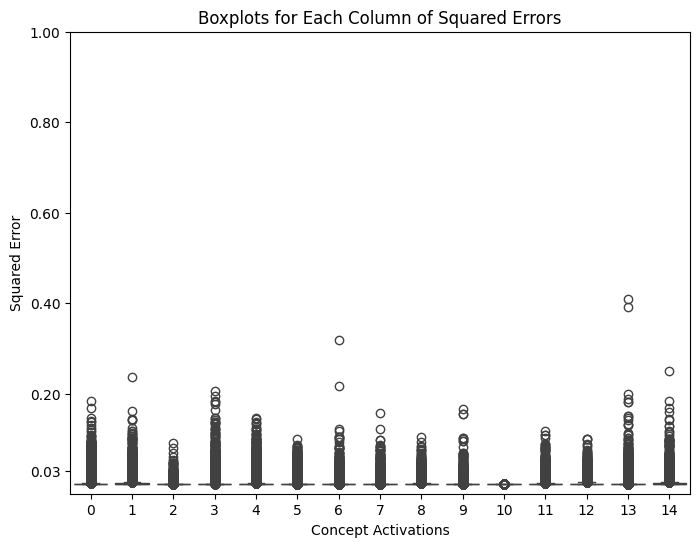

In [6]:
vis.concept_boxplots(mse_array)

Explained variance by component 1: 0.26
Explained variance by component 2: 0.20


/home/manni/physioex/physioex/explain/concepts/visualization.py:91: UserWarning: The palette list has more values (15) than needed (14), which may not be intended.
  sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)


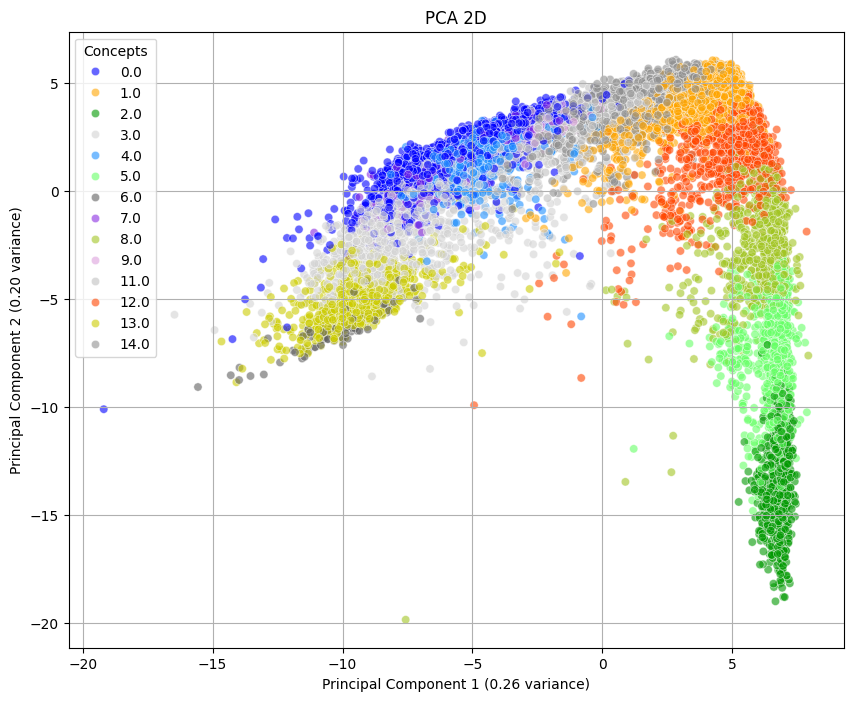

In [7]:
vis.plot_pca_2d(emb_array, con_array, p_palette=vis.concept_palette_protoae_alldata, percentage=1, legend_title="Concepts")

Explained variance by component 1: 0.33
Explained variance by component 2: 0.27


/home/manni/physioex/physioex/explain/concepts/visualization.py:91: UserWarning: The palette list has more values (15) than needed (14), which may not be intended.
  sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=colors, palette=palette, alpha=0.6)


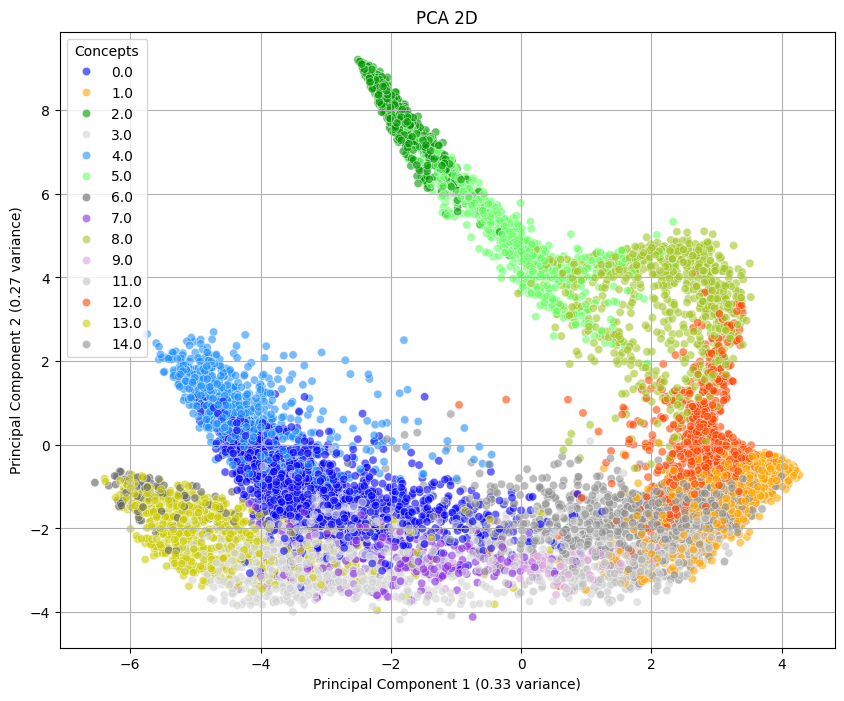

In [8]:
vis.plot_pca_2d(con_emb_array, con_array, p_palette=vis.concept_palette_protoae_alldata, percentage=1, legend_title="Concepts")